# Cognition and Computation Project

## Import Libraries

In [1]:
import os
import math
import json
import random
import requests

from IPython.display import display, clear_output
from urllib.parse import quote

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import scipy
import pandas as pd
import numpy as np
import seaborn as sns

## Dataset

[The Quick, Draw! Dataset](https://github.com/googlecreativelab/quickdraw-dataset)

```quote
The Quick Draw Dataset is a collection of 50 million drawings across 345 categories, contributed by players of the game Quick, Draw!. The drawings were captured as timestamped vectors, tagged with metadata including what the player was asked to draw and in which country the player was located.
```

### Selected Categories

Original categories list was divided into 10 broad categories that are stored in the `categories.json` file.

In [3]:
DATASET_BASE_URL = "https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/"
IMG_SHAPE = (28, 28)
RANDOM_SEED = 123
BATCH_SIZE = 32
CLASS_NUM = 10

categories_json_filename = 'categories.json'

In [5]:
# Downloading categories
%%capture
!wget -O {categories_json_filename} "https://raw.githubusercontent.com/pavelihno/cognition-computation-project/master/data/{categories_json_filename}"

--2026-01-10 08:49:12--  https://raw.githubusercontent.com/pavelihno/cognition-computation-project/master/data/categories.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6018 (5.9K) [text/plain]
Saving to: ‘categories.json’

categories.json     100%[===================>]   5.88K  --.-KB/s    in 0s      

2026-01-10 08:49:13 (55.3 MB/s) - ‘categories.json’ saved [6018/6018]



In [6]:
categories_json = {}
with open(categories_json_filename, 'r') as f:
    categories_json = json.load(f)

# display(categories_json)

In [7]:
def get_quickdraw_data(categories_json, total_classes=5, samples_per_class=2000, seed=123):
    """
    categories_json: dict {SuperCategory: [list of subcategories]}
    total_classes: total number of classes to sample
    samples_per_class: number of samples to download per class
    """
    selected_classes = []

    random.seed(seed)

    # 1. Hierarchical Sampling
    pool = {k: list(v) for k, v in categories_json.items()}
    while len(selected_classes) < total_classes:
        broad_cats = [c for c, items in pool.items() if len(items) > 0]
        if not broad_cats:
            break

        # Uniformly select broad category
        broad_cat = random.choice(broad_cats)

        # Uniformly sample sub-category
        sub_cat = random.choice(pool[broad_cat])

        selected_classes.append((sub_cat, broad_cat))

        # Exclude sampled sub-category from further sampling
        pool[broad_cat].remove(sub_cat)

    # 2. Downloading data
    X, Y, Y_super = [], [], []

    for i, (sub_cat, broad_cat) in enumerate(selected_classes):
        file_name = f'{quote(sub_cat)}.npy'
        url = DATASET_BASE_URL + file_name

        print(f'Downloading {sub_cat} ({broad_cat})...')
        res = requests.get(url)
        data = np.frombuffer(
            res.content, dtype=np.uint8, offset=80
        )
        data = data.reshape(-1, math.prod(IMG_SHAPE))[:samples_per_class]

        X.append(data)
        Y.append(np.full(len(data), i))  # Sub-class label (from 0 to total_classes-1)

        # Numerical label for broad category
        Y_super.append(
            [list(categories_json.keys()).index(broad_cat)] * len(data)
        )

    X = np.concatenate(X) / 255.0  # Normalize [0,1]
    Y = np.concatenate(Y)

    return torch.FloatTensor(X), torch.LongTensor(Y), selected_classes

In [ ]:
# Downloading previously used data
%%capture
quickdraw_data_filename = 'quickdraw_data.npz'

!wget -O {quickdraw_data_filename} "https://raw.githubusercontent.com/pavelihno/cognition-computation-project/master/data/{quickdraw_data_filename}"

loaded_data = np.load(quickdraw_data_filename, allow_pickle=True)

sketch_data = torch.from_numpy(loaded_data['data'])
sketch_labels = torch.from_numpy(loaded_data['labels'])
sketch_categories = loaded_data['categories'].tolist()

In [8]:
# Sampling new data
sketch_data, sketch_labels, sketch_categories = get_quickdraw_data(
    categories_json, total_classes=CLASS_NUM, samples_per_class=2000, seed=RANDOM_SEED
)

In [ ]:
# Saving sampled data
quickdraw_data_filename = 'quickdraw_data.npz'

save_data = sketch_data.numpy()
save_labels = sketch_labels.numpy()
save_categories = np.array(sketch_categories, dtype=object)

np.savez_compressed(
    quickdraw_data_filename,
    data=save_data,
    labels=save_labels,
    categories=save_categories
)

In [9]:
def show_img(
    img, sub_category=None, broad_category=None, predicted_sub_category=None, predicted_broad_category=None
):
    if sub_category is not None:
        print(f'Sub-category: {sub_category}')
    if broad_category is not None:
        print(f'Broad category: {broad_category}')
    if predicted_sub_category is not None:
        print(f'Predicted sub-category: {predicted_sub_category}')
    if predicted_broad_category is not None:
        print(f'Predicted broad category: {predicted_broad_category}')
    img = img.cpu()
    plt.imshow(img, cmap='gray')
    plt.show()


def compare_imgs(imgs, sub_category, broad_category):
    print(f'Sub-category: {sub_category}')
    print(f'Broad category: {broad_category}')
    n_imgs = len(imgs)
    for i, img in enumerate(imgs):
        img = img.cpu()
        plt.subplot(1, n_imgs, i+1)
        plt.imshow(img, cmap='gray')
    plt.show()


def show_class_distribution(labels, categories):
    counts = pd.Series(labels.numpy()).value_counts().sort_index()

    df_meta = pd.DataFrame(
        categories, columns=['sub_category', 'broad_category']
    )
    df_meta['samples'] = counts.values

    sns.set_theme(style='whitegrid')
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    sns.barplot(
        data=df_meta,
        x='sub_category', y='samples', hue='broad_category',
        palette='viridis', dodge=False, legend=False, ax=axes[0]
    )
    axes[0].set_title('Samples per Sub-Category')
    axes[0].tick_params(axis='x', rotation=45)

    sns.barplot(
        data=df_meta.groupby('broad_category')['samples'].sum().reset_index(),
        x='broad_category', y='samples', hue='broad_category',
        palette='magma', legend=False, ax=axes[1]
    )
    axes[1].set_title('Samples per Broad Category')
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

Sub-category: frog
Broad category: Animals


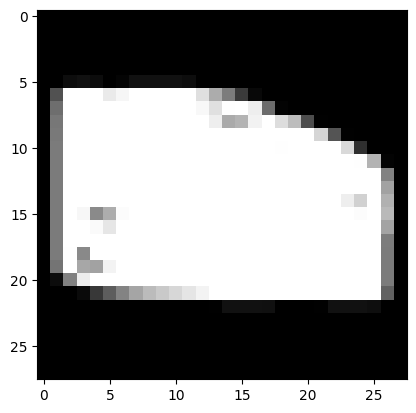

In [10]:
img_idx = 1501
img = sketch_data[img_idx]
label = sketch_labels[img_idx]
sub_category, broad_category = sketch_categories[label]

show_img(
    img.reshape(IMG_SHAPE),
    sub_category=sub_category,
    broad_category=broad_category
)

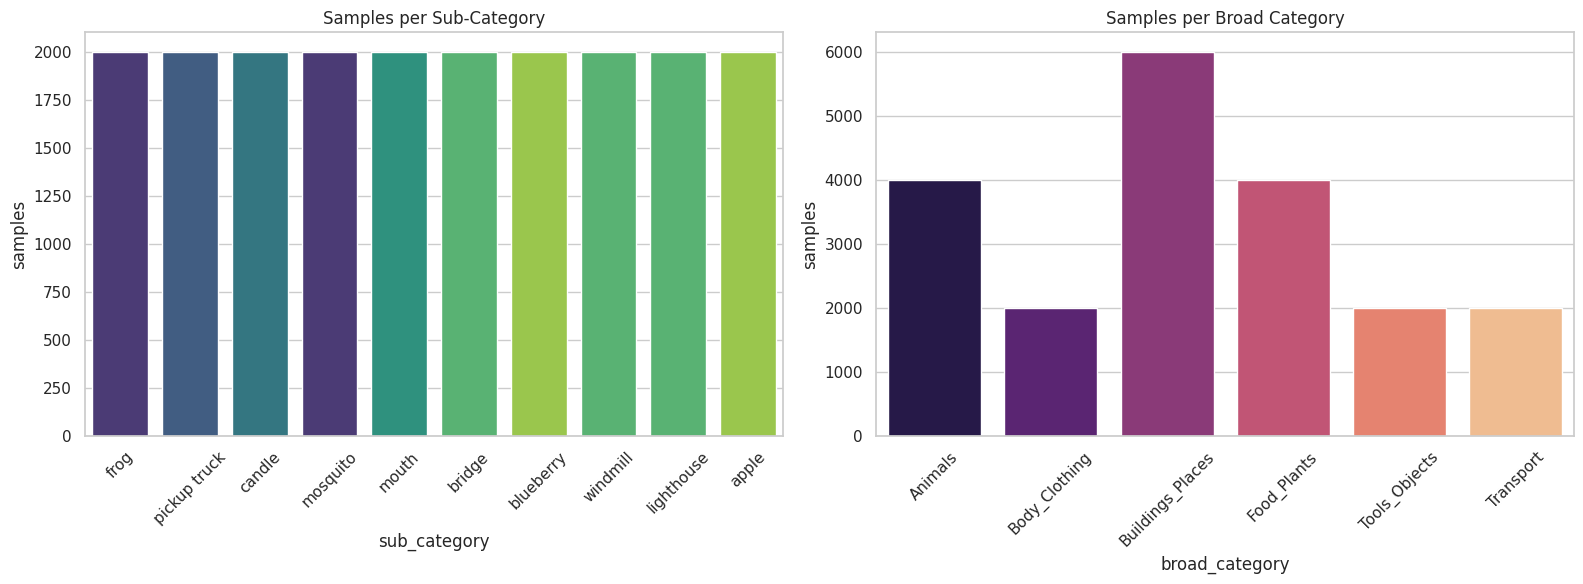

In [11]:
show_class_distribution(sketch_labels, sketch_categories)

In [12]:
# Create train and test dataloaders
train_size = int(0.8 * len(sketch_data))
test_size = len(sketch_data) - train_size

train_data, test_data = torch.utils.data.random_split(
    sketch_data, [train_size, test_size],
    generator=torch.Generator().manual_seed(RANDOM_SEED)
)

train_labels, test_labels = torch.utils.data.random_split(
    sketch_labels, [train_size, test_size],
    generator=torch.Generator().manual_seed(RANDOM_SEED)
)

train_dataset = TensorDataset(
    train_data.dataset[train_data.indices],
    train_labels.dataset[train_labels.indices]
)
test_dataset = TensorDataset(
    test_data.dataset[test_data.indices],
    test_labels.dataset[test_labels.indices]
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f'Training dataset size: {len(train_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

device_name = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device_name)

print(f'Using device: {device_name}')

Training dataset size: 16000
Test dataset size: 4000
Using device: cpu


## Training

In [13]:
def train_model(
    model, train_loader, optimizer_cls, loss_fn, optimizer_params={}, self_supervised=False, epochs=10,
    device=None, filename=None, checkpoint_freq=5, checkpoint_dir=None, checkpoint_path=None
):
    model.to(device)

    start_epoch = 0

    optimizer = optimizer_cls(model.parameters(), **optimizer_params)

    if checkpoint_path is not None:
        if os.path.exists(checkpoint_path):
            checkpoint = torch.load(checkpoint_path, map_location=device)

            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            start_epoch = checkpoint['epoch']
            loss = checkpoint['loss']

            # Override optimizer params
            for group in optimizer.param_groups:
                for k, v in optimizer_params.items():
                    if k != 'params':
                        group[k] = v

            print(f'Resumed from epoch {start_epoch}, Loss: {loss:.4f}')

    for epoch in range(start_epoch, epochs):
        model.train()

        running_loss = 0.0
        n_samples = 0

        for data, targets in train_loader:
            data = data.to(device)
            targets = targets.to(device) if not self_supervised else data.to(device)

            optimizer.zero_grad()
            outputs = model(data)
            loss = loss_fn(outputs, targets)

            running_loss += loss.item()
            n_samples += data.size(0)

            loss.backward()
            optimizer.step()

        epoch_loss = running_loss / n_samples

        if epoch % 10 == 0 or epoch == epochs - 1:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}')

        if checkpoint_dir and (epoch + 1) % checkpoint_freq == 0:
            checkpoint_path = os.path.join(
                checkpoint_dir,
                f'{filename}_check_{epoch+1}.pth'
            )
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': epoch_loss,
            }, checkpoint_path)
            print(f'Checkpoint saved: {checkpoint_path}')

    if filename is not None:
        file_path = f'{filename}.pth'
        torch.save(model.state_dict(), file_path)
        print(f'Model weights saved to "{file_path}"')

    return model


def load_model(model, file_path, download=True, from_checkpoint=False, device=None):

    if download:
        !wget -O {file_path} "https://raw.githubusercontent.com/pavelihno/cognition-computation-project/master/models/{file_path}"

    state_file = torch.load(file_path, map_location=device)
    if from_checkpoint:
        model.load_state_dict(state_file['model_state_dict'])
    else:
        model.load_state_dict(state_file)

    model.to(device)
    print(f'Model weights loaded from "{file_path}"')
    return model

## Variational Autoencoder (VAE)

[An Introduction to Variational Autoencoders. Diederik P. Kingma, Max Welling](https://arxiv.org/pdf/1906.02691)

![VAE Architecture](https://upload.wikimedia.org/wikipedia/commons/1/11/Reparameterized_Variational_Autoencoder.png)

### Objective Function

$$ELBO = \underbrace{\mathbb{E}_{q_\phi(z|x)}[\log p_\theta(x|z)]}_{\text{Reconstruction Log-Likelihood}} - \underbrace{D_{KL}(q_\phi(z|x) || p(z))}_{\text{KL Divergence Regularizer}}$$

KL Divergence Regularizer

$$D_{KL} = -\frac{1}{2} \sum_{j=1}^J (1 + \log(\sigma_j^2) - \mu_j^2 - \sigma_j^2)$$

The goal of a VAE is to maximize the ELBO. In practice, we minimize the Negative ELBO as our loss function.


In [14]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(hidden_dim // 2, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim // 2, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def decode(self, z):
        return self.decoder(z)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

In [15]:
def recon_log_likelihood(recon_x, x):
    return -F.binary_cross_entropy(recon_x, x, reduction='sum')


def kl_divergence(mu, logvar):
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())


def elbo(recon_x, x, mu, logvar):
    return recon_log_likelihood(recon_x, x) - kl_divergence(mu, logvar)


def vae_loss_fn(outputs, x):
    recon_x, mu, logvar = outputs
    return -elbo(recon_x, x, mu, logvar)

In [ ]:
vae_model = VAE(
    input_dim=IMG_SHAPE[0] * IMG_SHAPE[1],
    hidden_dim=512,
    latent_dim=32
)
optimizer_cls = torch.optim.Adam
optimizer_params = {'lr': 0.001}

num_linear_layers = len([m for m in vae_model.encoder if isinstance(m, nn.Linear)]) + 1

In [ ]:
# Training VAE
vae_model = train_model(
    model=vae_model,
    train_loader=train_loader,
    optimizer_cls=optimizer_cls,
    optimizer_params=optimizer_params,
    loss_fn=vae_loss_fn,
    self_supervised=True,
    epochs=300,
    device=device,
    filename='vae_model',
    checkpoint_freq=100,
    checkpoint_dir='checkpoints',
    checkpoint_path='checkpoints/vae.pth_check_250.pth'
)

Resumed from epoch 250, Loss: 166.3758
Epoch 251/300, Loss: 166.5585
Epoch 261/300, Loss: 166.0591
Epoch 271/300, Loss: 165.5654
Epoch 281/300, Loss: 165.4102
Epoch 291/300, Loss: 165.0990
Epoch 300/300, Loss: 164.9191
Checkpoint saved: checkpoints/vae.pth_check_300.pth
Model weights saved to "vae.pth.pth"


In [17]:
# Loading VAE
%%capture
vae_model = load_model(
    model=vae_model,
    file_path='vae_model.pth',
    download=True,
    from_checkpoint=False,
    device=device
)

--2026-01-10 08:50:54--  https://raw.githubusercontent.com/pavelihno/cognition-computation-project/master/models/vae_model.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4372665 (4.2M) [application/octet-stream]
Saving to: ‘vae_model.pth’

vae_model.pth       100%[===================>]   4.17M  --.-KB/s    in 0.07s   

2026-01-10 08:50:54 (55.9 MB/s) - ‘vae_model.pth’ saved [4372665/4372665]

Model weights loaded from "vae_model.pth"


Sub-category: apple
Broad category: Food_Plants


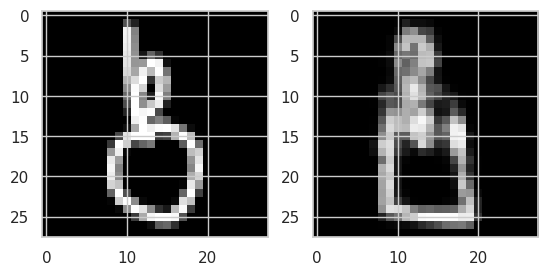

In [ ]:
test_idx = 1000
test_img, test_label = test_dataset[test_idx]
test_sub_category, test_broad_category = sketch_categories[test_label]

recon_img, _, _ = vae_model(test_img.to(device))

compare_imgs(
    [img.reshape(IMG_SHAPE) for img in [test_img, recon_img.detach()]],
    sub_category=test_sub_category,
    broad_category=test_broad_category
)

## Visualizing receptive fields

To visualize receptive fields in a VAE, we use a linear projection method that collapses the multi-layer encoder into a single weight matrix. This allows to build projection from each hidden layer to input pixels.

Layer 1. Some receptive fields act as edge detectors. They respond to simple local shapes, forms in specific parts of the image.

Layer 2. These fields are more complex and combine the edges from Layer 1 into parts or shapes.

Layer 3. These are global templates that may look like entire objects. They represent the "concepts" the VAE has learned from training data.

In [19]:
def get_effective_weights(model, layer_idx=None):
    weights = []

    # Input -> Linear -> fc_mu -> Latent
    for m in model.encoder:
        if isinstance(m, nn.Linear):
            weights.append(m.weight.data)
    weights.append(model.fc_mu.weight.data)

    eff_w = weights[0]
    for i in range(1, layer_idx + 1):
        eff_w = torch.mm(weights[i], eff_w)

    return eff_w   # [input_dim, latent_dim]


def plot_fields(weights, title, img_shape, max_plots=16):
    total_available = weights.shape[0]
    n_plots = min(total_available, max_plots)

    n_cols = math.ceil(math.sqrt(n_plots))
    n_rows = math.ceil(n_plots / n_cols)

    fig, axs = plt.subplots(
        n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5)
    )
    fig.suptitle(title, fontsize=16, y=1.01)

    for i in range(n_plots):
        ax = axs[i // n_cols, i % n_cols]

        field = weights[i, :].view(img_shape).cpu().numpy()

        im = ax.imshow(field, cmap='RdBu_r')
        ax.axis('off')
        ax.set_title(f'{i}')

    plt.tight_layout()
    plt.show()

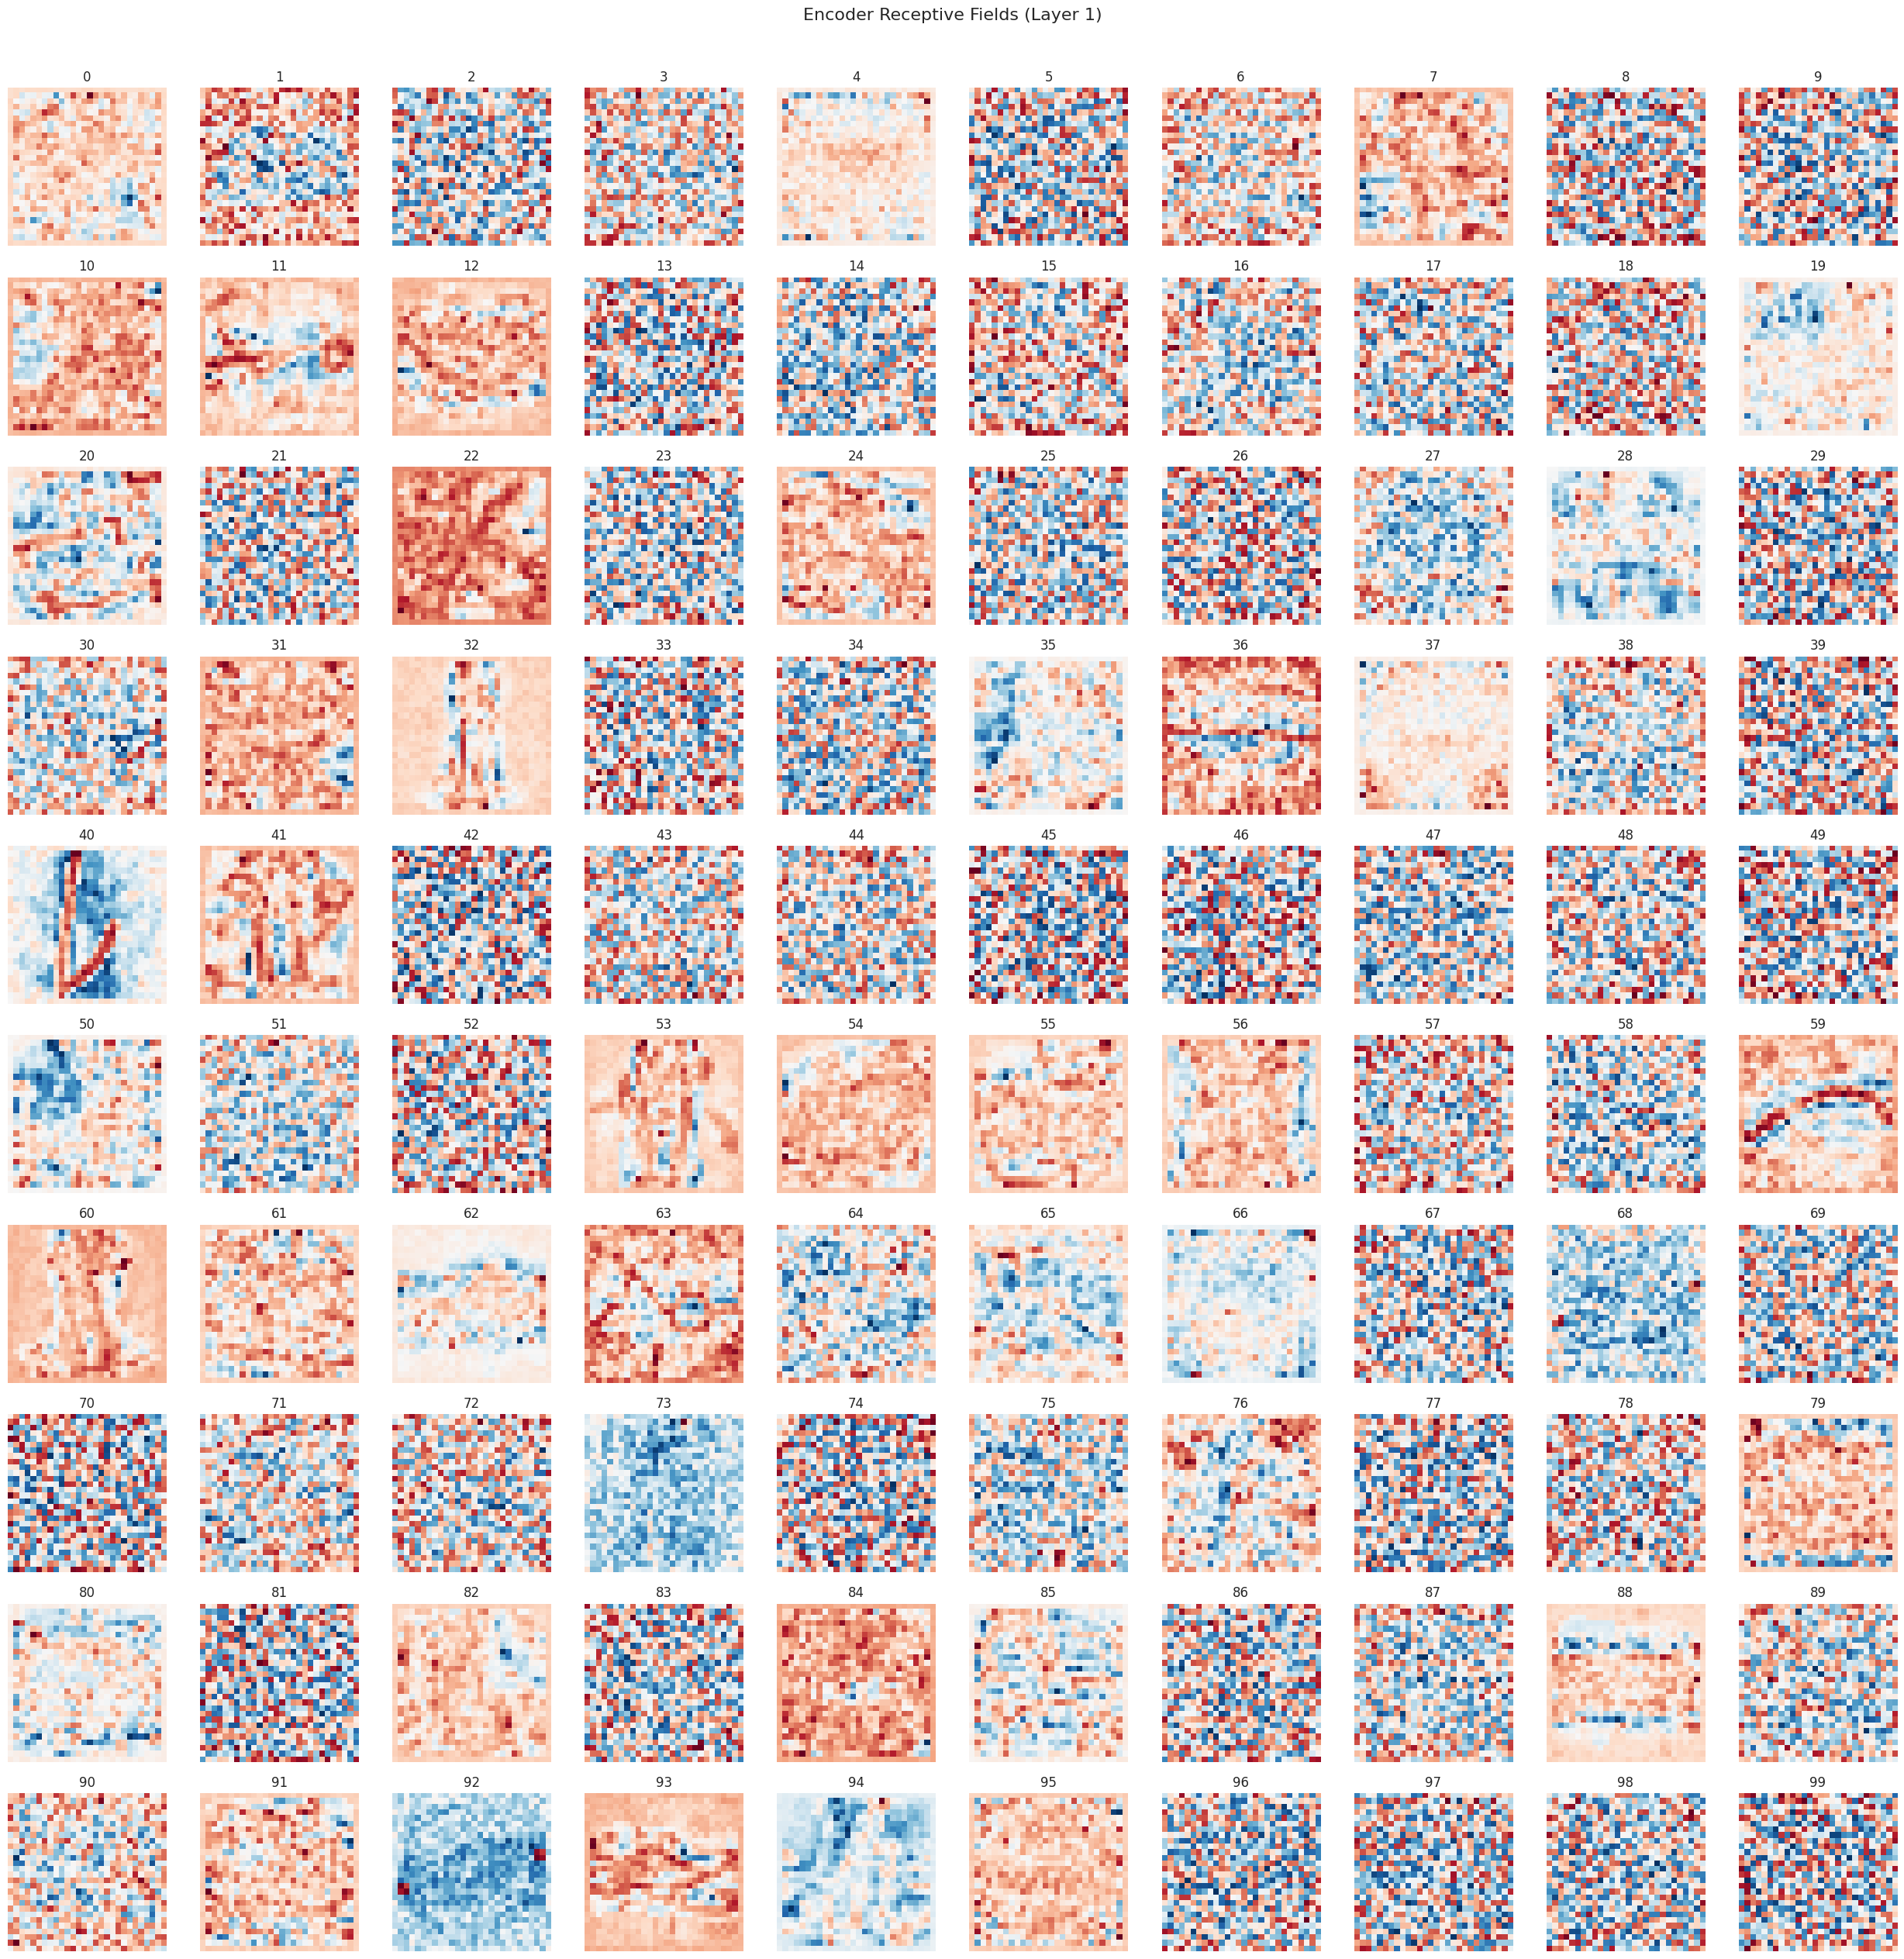

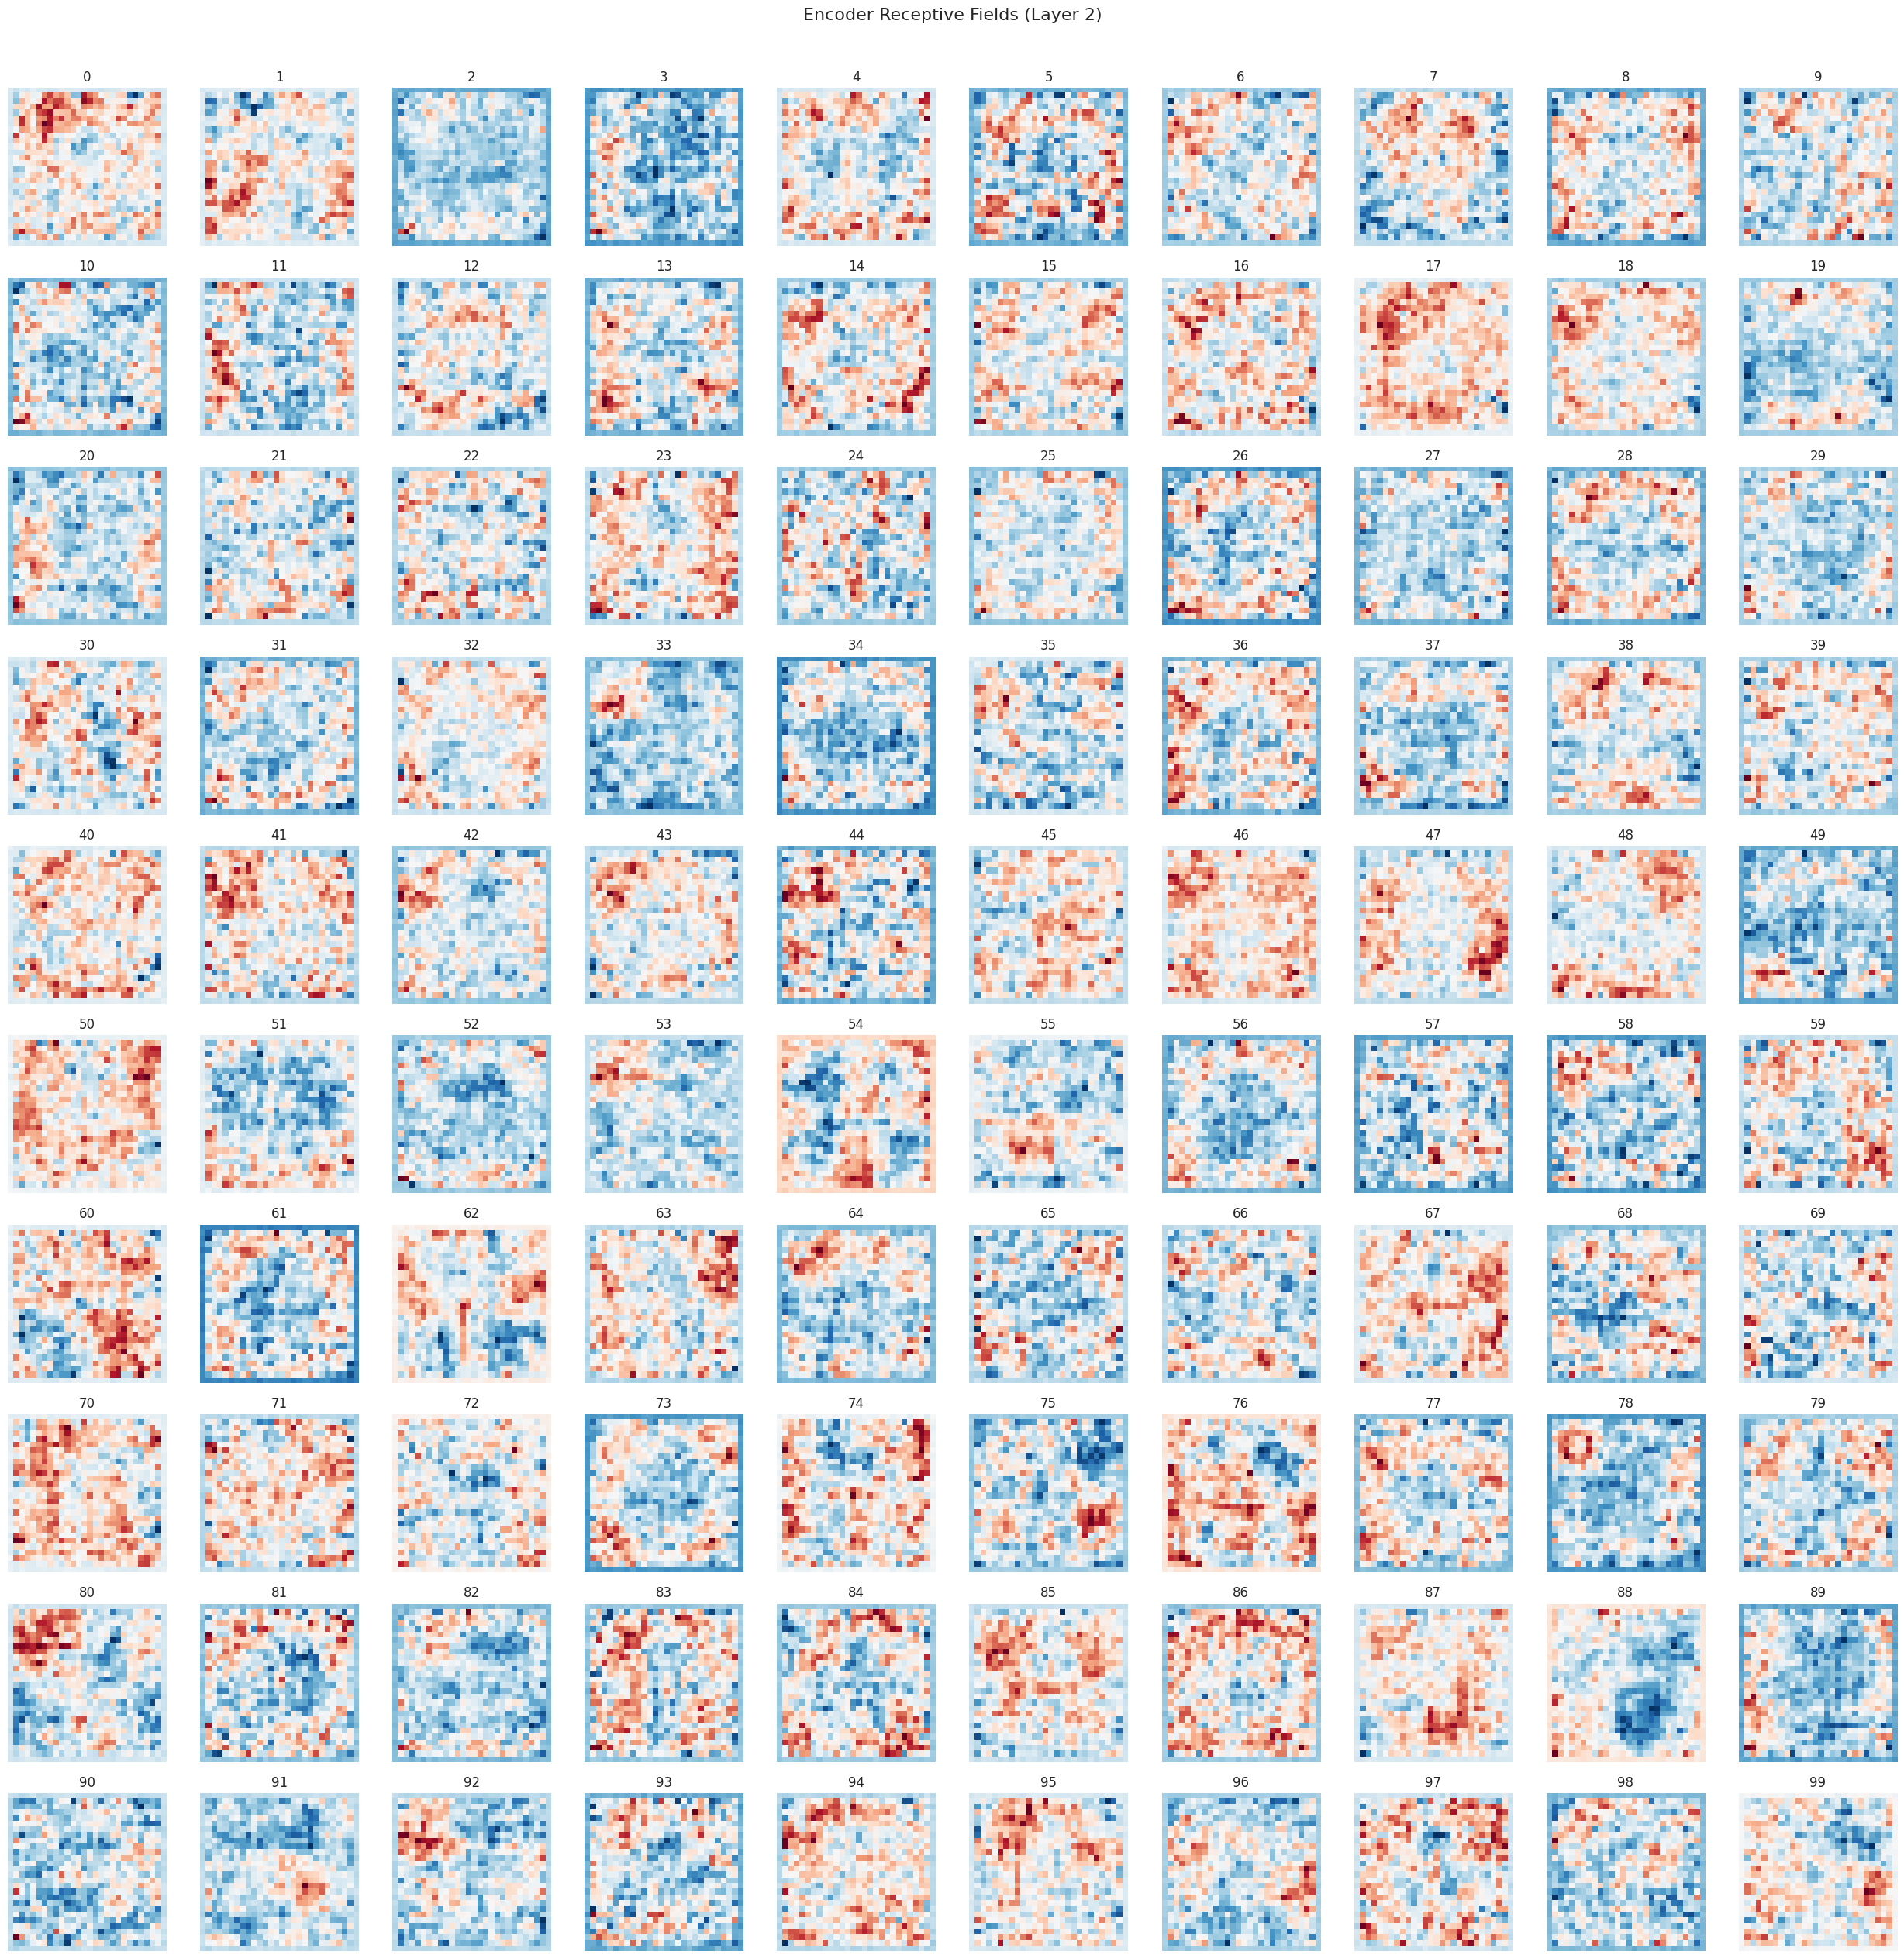

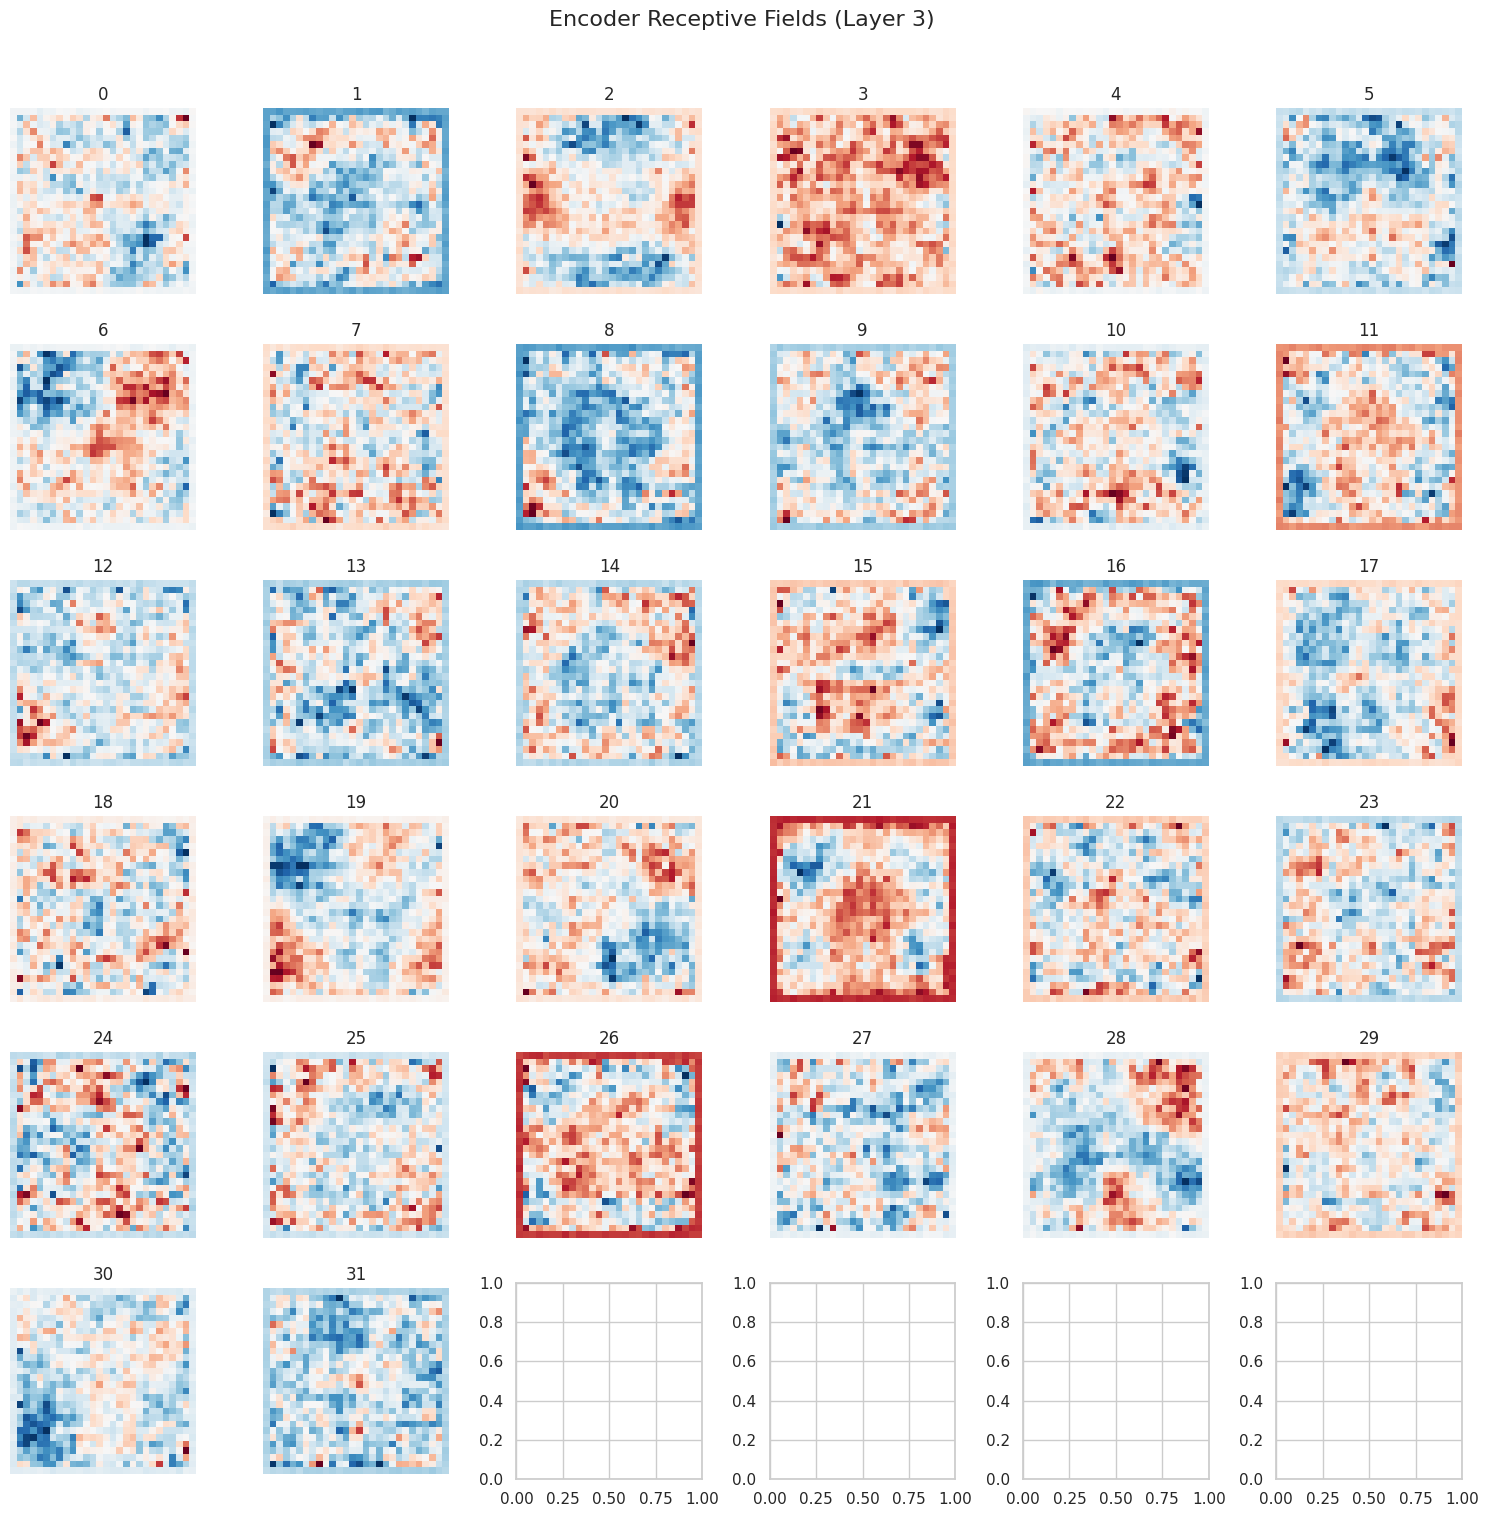

In [ ]:
for layer_idx in range(num_linear_layers):
    enc_w = get_effective_weights(
        vae_model, layer_idx=layer_idx
    )
    plot_fields(
        enc_w, f'Encoder Receptive Fields (Layer {layer_idx+1})', IMG_SHAPE, max_plots=100
    )

## Clustering internal representations

In [32]:
def get_mean_representations(representations, labels):
    return {
        label: np.mean(representations[labels == label], axis=0)
        for label in np.unique(labels)
    }


def show_clusters(
    representations, labels, categories
):
    mean_representations = get_mean_representations(representations, labels)
    unique_labels = sorted(mean_representations.keys())
    representations_matrix = np.concatenate([
        np.expand_dims(mean_representations[label], axis=0)
        for label in unique_labels
    ])

    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(representations_matrix)

    fig, ax = plt.subplots(figsize=(12, 10))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], s=100)

    for i, label in enumerate(unique_labels):
        sub_category = categories[label][0]
        plt.annotate(
            sub_category,
            (pca_result[i, 0], pca_result[i, 1]),
            xytext=(10, 10),
            textcoords='offset points',
            fontsize=10,
            bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7)
        )

    plt.tight_layout()
    plt.show()


def show_dendrogram(
    representations, labels, categories
):
    mean_representations = get_mean_representations(representations, labels)
    unique_labels = sorted(mean_representations.keys())
    representations_matrix = np.concatenate([
        np.expand_dims(mean_representations[label], axis=0)
        for label in unique_labels
    ])

    fig, ax = plt.subplots(figsize=(14, 8))
    linkage = scipy.cluster.hierarchy.linkage(
        representations_matrix, method='complete'
    )

    dendrogram_labels = [categories[label][0] for label in unique_labels]

    dendrogram = scipy.cluster.hierarchy.dendrogram(
        linkage,
        labels=dendrogram_labels,
        leaf_rotation=45,
        leaf_font_size=12
    )

    plt.tight_layout()
    plt.show()

======= Latent Space =======


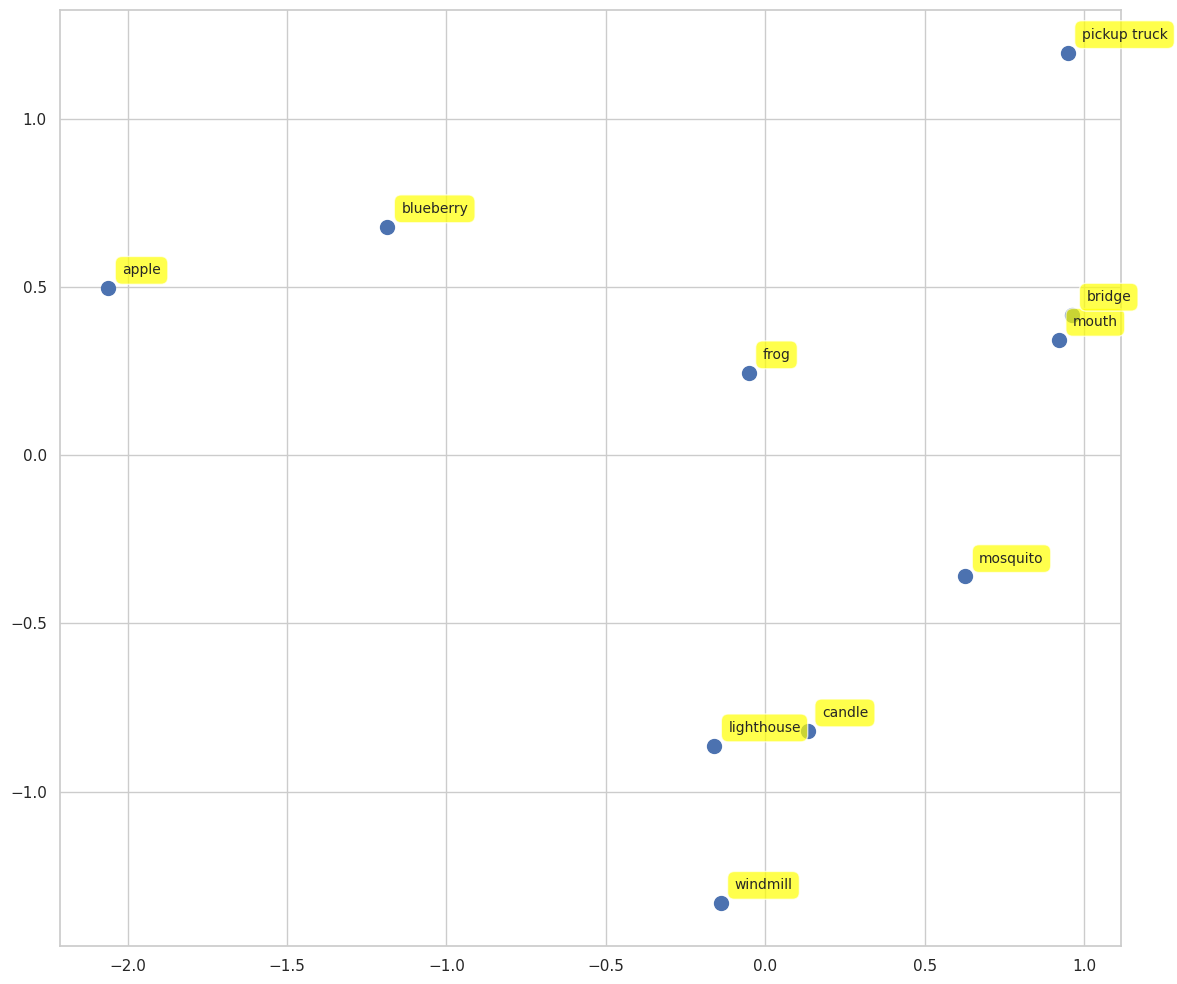

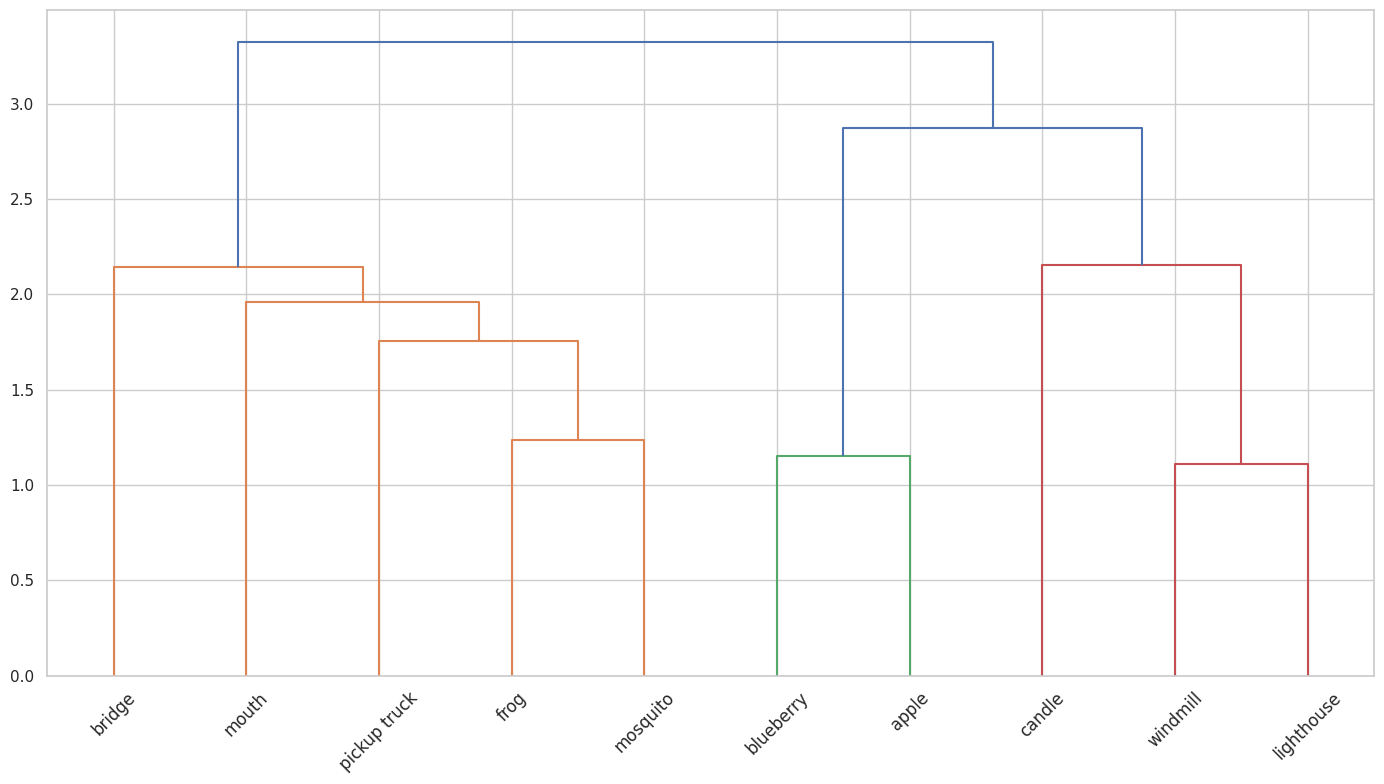

In [33]:
vae_model.eval()

all_latent_representations = []
all_labels = []

with torch.no_grad():
    for data, labels in test_loader:
        data = data.to(device)
        mu, logvar = vae_model.encode(data)
        all_latent_representations.append(mu.cpu().numpy())
        all_labels.append(labels.numpy())

latent_representations = np.concatenate(all_latent_representations, axis=0)
test_labels_np = np.concatenate(all_labels, axis=0)

print('======= Latent Space =======')
show_clusters(latent_representations, test_labels_np, sketch_categories)
show_dendrogram(latent_representations, test_labels_np, sketch_categories)

## Linear read-out layers

In [21]:
class LinearReadOutLayer(nn.Module):
    def __init__(self, n_input, n_output=10) -> None:
        super(LinearReadOutLayer, self).__init__()

        self.linear = nn.Linear(n_input, n_output)

    def forward(self, x):
        return self.linear(x)


class LinearReadOutWrapper(nn.Module):
    def __init__(self, vae, linear_idx, n_output):
        super(LinearReadOutWrapper, self).__init__()

        self.vae = vae
        self.linear_idx = linear_idx

        # All linear layers of the encoder
        self.enc_linears = [m for m in vae.encoder if isinstance(m, nn.Linear)]
        all_probes = self.enc_linears + [vae.fc_mu]

        # Dimensions of the specific linear layer
        selected_layer = all_probes[linear_idx]
        n_input = selected_layer.out_features

        self.readout = LinearReadOutLayer(n_input, n_output)

        # Freezing VAE params
        for param in self.vae.parameters():
            param.requires_grad = False

    def forward(self, x):
        x = x.view(x.size(0), -1)

        feat = x
        linear_count = 0

        for module in self.vae.encoder:
            feat = module(feat)
            if isinstance(module, nn.Linear):
                if linear_count == self.linear_idx:
                    return self.readout(feat)
                linear_count += 1

        feat = self.vae.fc_mu(feat)
        return self.readout(feat)

In [ ]:
linear_layers = []

for layer_idx in range(num_linear_layers):
    linear_readout_wrapper = LinearReadOutWrapper(
        vae=vae_model,
        linear_idx=layer_idx,
        n_output=len(sketch_categories)
    ).to(device)

    linear_layers.append({
        'linear_readout': linear_readout_wrapper,
        'filename': f'linear_readout_{layer_idx+1}'
    })

In [23]:
for layer_idx, linear_layer_dict in enumerate(linear_layers):
    print(f'======= Layer {layer_idx + 1} =======')

    linear_readout_wrapper = linear_layer_dict['linear_readout']
    filename = linear_layer_dict['filename']

    train_model(
        model=linear_readout_wrapper,
        train_loader=train_loader,
        optimizer_cls=torch.optim.Adam,
        optimizer_params={'lr': 0.001},
        loss_fn=nn.CrossEntropyLoss(),
        epochs=50,
        device=device,
        filename=filename
    )

======= Layer 1 =======
Epoch 1/50, Loss: 0.0456
Epoch 11/50, Loss: 0.0369
Epoch 21/50, Loss: 0.0369
Epoch 31/50, Loss: 0.0369
Epoch 41/50, Loss: 0.0360
Epoch 50/50, Loss: 0.0357
Model weights saved to "linear_readout_1.pth"
======= Layer 2 =======
Epoch 1/50, Loss: 0.0393
Epoch 11/50, Loss: 0.0308
Epoch 21/50, Loss: 0.0304
Epoch 31/50, Loss: 0.0301
Epoch 41/50, Loss: 0.0300
Epoch 50/50, Loss: 0.0300
Model weights saved to "linear_readout_2.pth"
======= Layer 3 =======
Epoch 1/50, Loss: 0.0609
Epoch 11/50, Loss: 0.0379
Epoch 21/50, Loss: 0.0369
Epoch 31/50, Loss: 0.0364
Epoch 41/50, Loss: 0.0361
Epoch 50/50, Loss: 0.0359
Model weights saved to "linear_readout_3.pth"


In [27]:
# Downloading and loading weights from file
%%capture
_loaded_linear_layers = []

for linear_layer_dict in linear_layers:
    linear_readout_wrapper = linear_layer_dict['linear_readout']
    filename = linear_layer_dict['filename']
    file_path = f'{filename}.pth'

    !wget -O {file_path} "https://raw.githubusercontent.com/pavelihno/cognition-computation-project/master/models/{file_path}"

    linear_readout_wrapper.load_state_dict(torch.load(file_path, map_location=device))
    linear_readout_wrapper.to(device)

    linear_layer_dict['linear_readout'] = linear_readout_wrapper
    _loaded_linear_layers.append(linear_layer_dict)

linear_layers = _loaded_linear_layers

In [27]:
def get_accuracy(model, test_loader, device=None):
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device)
            labels = labels.to(device)

            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy


def show_confusion_matrix(model, test_loader, categories, device=None):
    model.to(device)
    model.eval()

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device)
            labels = labels.to(device)

            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=[c[0] for c in categories],
        yticklabels=[c[0] for c in categories]
    )
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

Layer 1: Test Accuracy: 0.6232


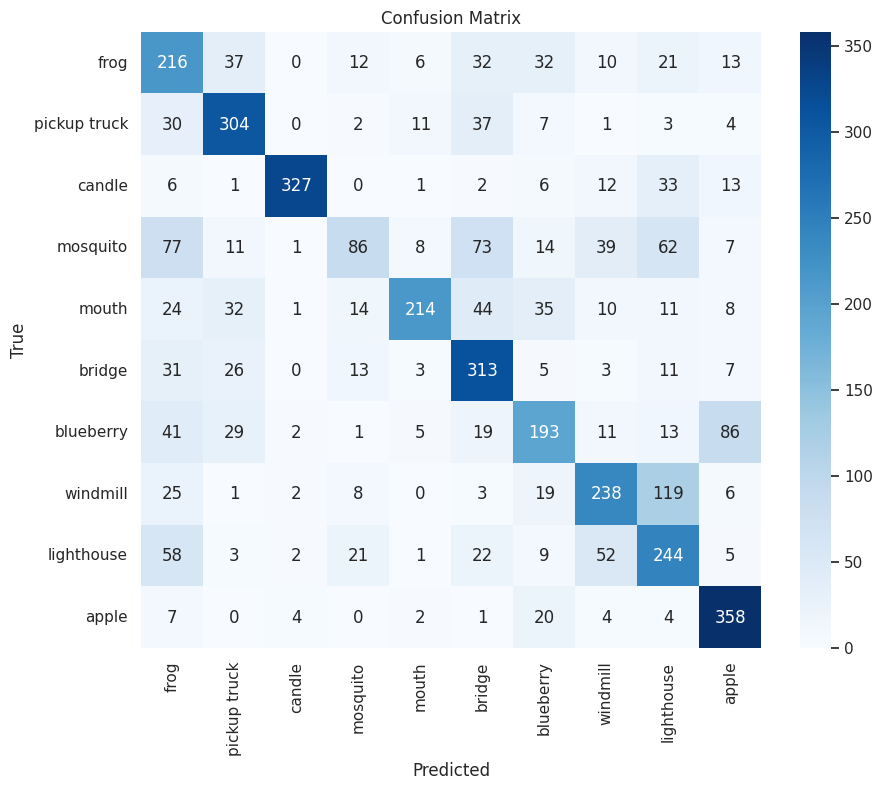

Layer 2: Test Accuracy: 0.6677


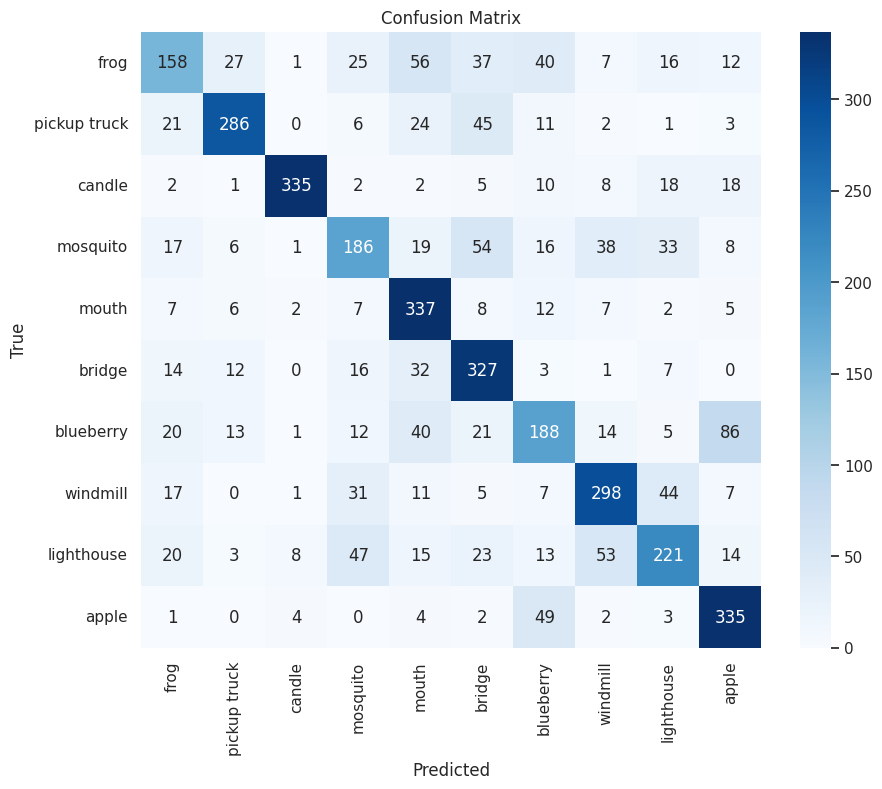

Layer 3: Test Accuracy: 0.6252


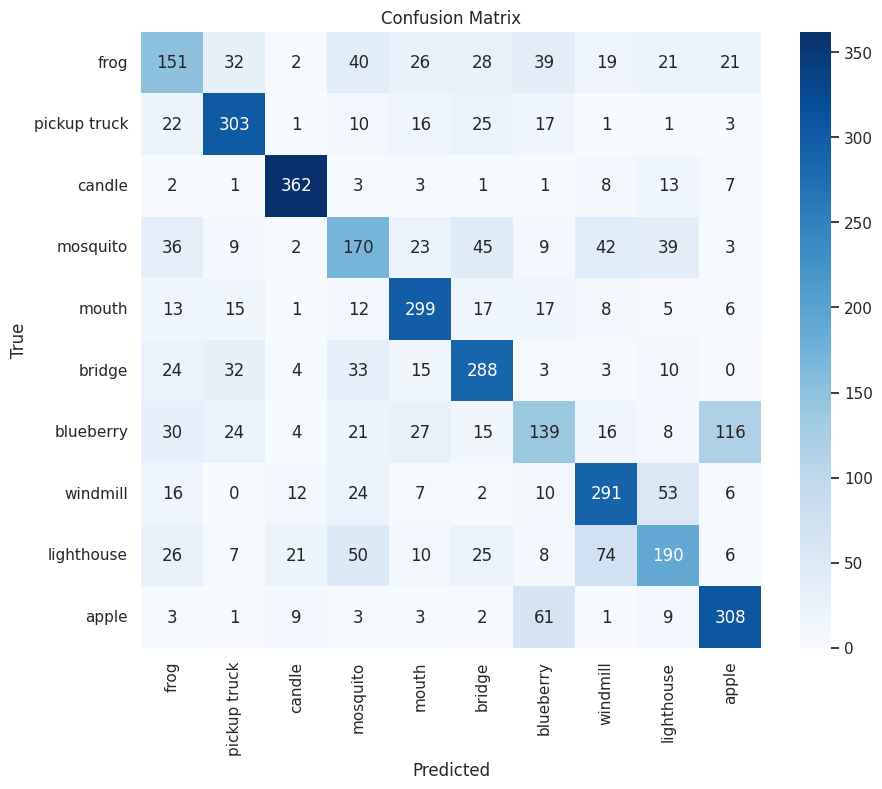

In [28]:
linear_accuracies = []

for layer_idx, linear_layer_dict in enumerate(linear_layers):
    linear_readout_wrapper = linear_layer_dict['linear_readout']

    accuracy = get_accuracy(
        model=linear_readout_wrapper,
        test_loader=test_loader,
        device=device
    )

    linear_accuracies.append(accuracy)

    print(f'Layer {layer_idx + 1}: Test Accuracy: {accuracy:.4f}')

    show_confusion_matrix(
        model=linear_readout_wrapper,
        test_loader=test_loader,
        categories=sketch_categories,
        device=device
    )